In [166]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from SerialSectionsReg import SerialSectionsReg
import cv2
from hephaestus.data.ndpwrapper_v2 import Slide_ndpread
from scipy.ndimage import label
from sklearn import tree

In [137]:
SAVE_PATH = "/workspace/skin/decision_tree/decision_input.csv"
LABEL_PATH= "/workspace/skin/decision_tree/data.csv"

In [2]:
for f in [file for file in os.listdir("result/inference_CSV/") if not file.startswith(".")]:
    tmp = os.path.join("result/inference_CSV/",f,"df.csv")
    print(f"'{tmp}',")

'result/inference_CSV/2019-10-30 02.15.32/df.csv',
'result/inference_CSV/2019-10-30 02.10.47/df.csv',
'result/inference_CSV/2019-10-30 02.09.05/df.csv',
'result/inference_CSV/2019-10-30 02.03.40/df.csv',
'result/inference_CSV/2019-10-30 02.04.50/df.csv',
'result/inference_CSV/2019-10-30 02.23.07/df.csv',
'result/inference_CSV/2019-10-30 02.18.03/df.csv',
'result/inference_CSV/2019-10-30 02.13.08/df.csv',
'result/inference_CSV/2019-10-30 02.02.21/df.csv',
'result/inference_CSV/350013D01170 - 2019-10-30 02.21.40/df.csv',
'result/inference_CSV/2019-10-30 02.14.37/df.csv',
'result/inference_CSV/2019-10-30 01.59.42/df.csv',
'result/inference_CSV/2019-10-30 02.01.19/df.csv',
'result/inference_CSV/2019-10-30 02.05.46/df.csv',
'result/inference_CSV/2019-10-30 02.19.24/df.csv',
'result/inference_CSV/2019-10-30 02.07.27/df.csv',


In [3]:
TEST_IMG = "result/inference_CSV/2019-10-30 02.01.19/df.csv"
ADIP_IMG = "result/inference_CSV/2019-10-30 02.02.21/df.csv"
ALL_IMG = ['result/inference_CSV/2019-10-30 02.15.32/df.csv',
            'result/inference_CSV/2019-10-30 02.10.47/df.csv',
            'result/inference_CSV/2019-10-30 02.09.05/df.csv',
            'result/inference_CSV/2019-10-30 02.03.40/df.csv',
            'result/inference_CSV/2019-10-30 02.04.50/df.csv',
            'result/inference_CSV/2019-10-30 02.23.07/df.csv',
            'result/inference_CSV/2019-10-30 02.18.03/df.csv',
            'result/inference_CSV/2019-10-30 02.13.08/df.csv',
            'result/inference_CSV/2019-10-30 02.02.21/df.csv',
            'result/inference_CSV/350013D01170 - 2019-10-30 02.21.40/df.csv',
            'result/inference_CSV/2019-10-30 02.14.37/df.csv',
            'result/inference_CSV/2019-10-30 01.59.42/df.csv',
            'result/inference_CSV/2019-10-30 02.01.19/df.csv',
            'result/inference_CSV/2019-10-30 02.05.46/df.csv',
            'result/inference_CSV/2019-10-30 02.19.24/df.csv',
            'result/inference_CSV/2019-10-30 02.07.27/df.csv',]
TEST_PATH = "/mnt/cephrbd/data/A19001_NCKU_SKIN/Image/20191106/2019-10-30 02.01.19.ndpi"
TEST_DIR = "/mnt/cephrbd/data/A19001_NCKU_SKIN/Image/20191106/"
TYPES = ['Background', 'Inflammatory infiltration', 'Adipose tissue', 'Sweat gland', 'Hair follicles', 'Dermis', 'Sebaceous gland', 'Epidermis', 'Blood vessels', 'Muscle']
COLOR_TABLE = {
    0:{"class": "Background",
       "colorcode": (255, 255, 255)
      },
    1:{"class": "Inflammatory infiltration",
       "colorcode": (255, 87, 34)
      },
    2:{"class": "Adipose tissue",
       "colorcode": (233, 30, 99)
      },
    3:{"class": "Sweat gland",
       "colorcode": (205, 220, 57)
      },
    4:{"class": "Hair follicles",
       "colorcode": (0, 0, 153)
      },
    5:{"class": "Dermis",
       "colorcode": (76, 175, 80)
      },
    6:{"class": "Sebaceous gland",
       "colorcode": (156, 39, 176)
      },
    7:{"class": "Epidermis",
       "colorcode": (3, 169, 244)
      },
    8:{"class": "Blood vessels", #??
       "colorcode": (255, 0, 0)
      },
    9:{"class": "Muscle", #??
       "colorcode": (181, 136, 24)
      },
}


In [4]:
def df2thumbnail(df):
    w = np.max(df["w"]) + 1
    h = np.max(df["h"]) + 1
    data = df.to_numpy().reshape((h, w, -1))[..., 2:].argmax(axis=-1)
    #img = np.tile(np.expand_dims(data, axis=-1), (1, 1, 3)).astype(np.uint8)
    color_img = np.zeros((*data.shape, 3), dtype=np.uint8)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            color_img[i, j] = COLOR_TABLE[data[i, j]]["colorcode"]
    return data, color_img

In [5]:
df = pd.read_csv(TEST_IMG)
df2thumbnail(df)

(array([[0, 0, 0, ..., 0, 4, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [  0,   0, 153],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
  

In [6]:
w = np.max(df["w"]) + 1
h = np.max(df["h"]) + 1
print(f"w = {w}, h = {h}")
types = list(df.columns[2:])
print(types)
data = df.to_numpy().reshape((h, w, -1))[..., 2:].argmax(axis=-1)
print(data.shape)

w = 278, h = 77
['Background', 'Inflammatory infiltration', 'Adipose tissue', 'Sweat gland', 'Hair follicles', 'Dermis', 'Sebaceous gland', 'Epidermis', 'Blood vessels', 'Muscle']
(77, 278)


In [7]:
print(type(data))

<class 'numpy.ndarray'>


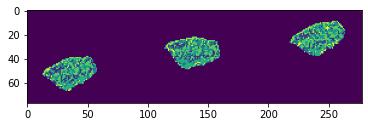

In [8]:
plt.imshow(data)
plt.show()

224


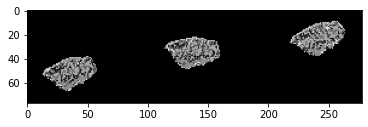

In [9]:
img = np.tile(np.expand_dims(data, axis=-1), (1, 1, 3)).astype(np.uint8)
img *= 28
print(np.max(img))
plt.imshow(img)
plt.show()

In [10]:
this_slide = Slide_ndpread(TEST_PATH)
thumbnail  = this_slide.get_patch_with_resize((0 , 0), src_sz = this_slide.get_size(), dst_sz=(w*16, h*16))

Width: 142080 , Height: 39168


(1232, 4448, 3)


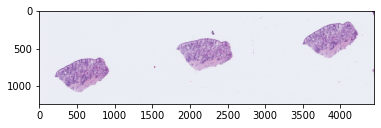

In [11]:
print(thumbnail.shape)
plt.imshow(thumbnail)
plt.show()

In [12]:
serialSectionsReg = SerialSectionsReg.SerialSectionsReg(thumbnail)
results = serialSectionsReg.cluster_and_registrate()

In [13]:
results

[{'top': 360, 'left': 1825, 'width': 750, 'height': 436, 'angle': 0}]

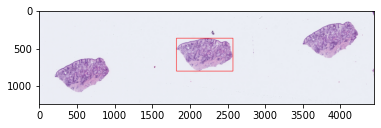

In [14]:
resize_ratio = 1
for res in results:
    cv2.rectangle(thumbnail, (res["left"]*resize_ratio, res["top"]*resize_ratio),
                              ((res["left"] + res["width"])*resize_ratio,
                              (res["top"] + res["height"])*resize_ratio),
                              color=(255, 0, 0), thickness=5)
plt.imshow(thumbnail)
plt.show()

## Criteria one: distant to epithelium
    epi_regions, inf_regions <-- test_img
    inf_centers, inf_weight <-- inf_regions
    epi_lines <-- epi_regions
    find min distance of inf_centers and epi_regions

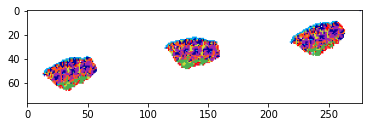

In [15]:
test_img, color_img = df2thumbnail(pd.read_csv(TEST_IMG))
plt.imshow(color_img)
plt.show()

In [16]:
def segment_region(mask):
    labels, numL = label(mask)
    label_indices = [(labels == i).nonzero() for i in range(1, numL+1)]
    return label_indices

def compute_areas(mask):
    labels, numL = label(mask)
    areas = [np.sum(labels == i) for i in range(0, numL+1)]
    return labels, areas

def get_tissue_map(mask):
    labels, numL = label(mask)
    return labels, numL

def find_nearest_dist_and_point(regions, centers):
    '''
    Arg: regions: [[xs, ys],...]
         centers: [[x_c, y_c]...]
    return: [(D1, p1), (D2, p2)...]
    '''
    xs = np.array([x for region in regions for x in region[0]])
    ys = np.array([y for region in regions for y in region[1]])
    xc = centers[:, 0]
    yc = centers[:, 1]
    
    dist_matrix =  np.square(np.tile(np.expand_dims(xs, 0), (len(xc), 1))-np.tile(np.expand_dims(xc, -1), (1, len(xs))))
    dist_matrix += np.square(np.tile(np.expand_dims(ys, 0), (len(yc), 1))-np.tile(np.expand_dims(yc, -1), (1, len(ys))))
    
    min_dist = np.min(dist_matrix, axis= -1)
    min_dist = np.sqrt(min_dist)
    min_arg  = np.argmin(dist_matrix, axis= -1)
    return min_dist, min_arg

In [126]:
def visualize_(image, centers, nearest):
    pseudoimage = np.copy(image)
    fig2 = plt.figure(figsize=(15, 10))
    ax = fig2.add_subplot(2, 1, 1)
    ax.imshow(pseudoimage)
    assert len(centers[0]) == len(nearest[0])
    assert len(centers[0]) == len(centers[1])
    assert len(nearest[0]) == len(nearest[1])
    for i in range(len(centers[0])):
        ax.plot([centers[1][i], nearest[1][i]], [centers[0][i], nearest[0][i]], linewidth=2, color='w')
    
    ax = fig2.add_subplot(2, 1, 2)
    plt.imshow(image)
    plt.show()

def find_mean_and_var_dist(image, min_dist, center_size):
    mean_dist = np.dot(min_dist, center_size)*1./np.sum(center_size)
    var_dist  = np.dot(np.square(min_dist-mean_dist), center_size)/np.sum(center_size)
    return mean_dist,var_dist

def arg2coord(args, regions):
    '''args: [(i-th tissue, [min-args]) ... ]
       regions: [[regions in i-th tissue] ... ], regions: [(xs, ys), (xs', ys')...]
    '''
    length = sum([len(arg) for i, arg in args])
    xs = np.zeros((length))
    ys = np.zeros((length))
    cur = 0
    for tissue_id, arg in args:
        x_map, y_map = zip(*regions[tissue_id])
        x_map = np.concatenate(x_map)
        y_map = np.concatenate(y_map)
        xs[cur:cur+len(arg)] = x_map[arg]
        ys[cur:cur+len(arg)] = y_map[arg]
        cur += len(arg)
    return xs, ys

def compute_cluster_distribution(test_img, cluster_id, target_id):
    epi_regions = segment_region(test_img == target_id)
    inf_regions = segment_region(test_img == cluster_id)
    tissue_map, numL = get_tissue_map(test_img > 0)

    inf_centers = [[] for i in range(0, numL+1)]
    epi_regions_by_tissue = [[] for i in range(0, numL+1)]
    inf_size    = [[] for i in range(0, numL+1)]

    for inf_region in inf_regions:
        tissue_id = tissue_map[inf_region[0][0], inf_region[1][0]]
        assert tissue_id <= numL
        inf_centers[tissue_id].append([inf_region[0].mean(), inf_region[1].mean()])
        inf_size[tissue_id].append(len(inf_region[0]))

    for epi_region in epi_regions:
        tissue_id = tissue_map[epi_region[0][0], epi_region[1][0]]
        assert tissue_id <= numL
        if len(epi_region[0]) >= 4:
            epi_regions_by_tissue[tissue_id].append(epi_region)

    min_dist = []
    min_arg  = []
    valid_center = ([], [])
    valid_size   = []
    for i in range(1, numL+1):
        if len(epi_regions_by_tissue[i]) == 0 or len(inf_centers[i]) == 0:
            continue
        valid_center[0].extend([x for x, y in inf_centers[i]])
        valid_center[1].extend([y for x, y in inf_centers[i]])
        valid_size.extend([sz for sz in inf_size[i]])
        dist_array, arg_array = find_nearest_dist_and_point(epi_regions_by_tissue[i], np.array(inf_centers[i]))
        min_dist.extend(dist_array)
        min_arg.append((i, arg_array))
    mean_dist = np.dot(min_dist, valid_size)*1./np.sum(valid_size)
    var_dist  = np.dot(np.square(min_dist-mean_dist), valid_size)/np.sum(valid_size)
    return mean_dist, var_dist

In [127]:
compute_cluster_distribution(test_img, cluster_id=1, target_id=7)

(9.258187276615994, 24.55977326820993)

In [117]:
epi_regions = segment_region(test_img == 7)
inf_regions = segment_region(test_img == 1)
tissue_map, numL = get_tissue_map(test_img > 0)

inf_centers = [[] for i in range(0, numL+1)]
epi_regions_by_tissue = [[] for i in range(0, numL+1)]

for inf_region in inf_regions:
    tissue_id = tissue_map[inf_region[0][0], inf_region[1][0]]
    assert tissue_id <= numL
    inf_centers[tissue_id].append([inf_region[0].mean(), inf_region[1].mean()])

for epi_region in epi_regions:
    tissue_id = tissue_map[epi_region[0][0], epi_region[1][0]]
    assert tissue_id <= numL
    if len(epi_region[0]) >= 4:
        epi_regions_by_tissue[tissue_id].append(epi_region)

min_dist = []
min_arg  = []
valid_center = ([], [])
valid_size   = []
for i in range(1, numL+1):
    if len(epi_regions_by_tissue[i]) == 0 or len(inf_centers[i]) == 0:
        continue
    valid_center[0].extend([x for x, y in inf_centers[i]])
    valid_center[1].extend([y for x, y in inf_centers[i]])
    dist_array, arg_array = find_nearest_dist_and_point(epi_regions_by_tissue[i], np.array(inf_centers[i]))
    min_dist.extend(dist_array)
    min_arg.append((i, arg_array))
print(min_dist)
print(min_arg)

[2.23606797749979, 1.0, 2.5, 2.23606797749979, 5.656854249492381, 2.23606797749979, 5.830951894845301, 4.031128874149275, 8.139410298049853, 2.8356333201827413, 2.8284271247461903, 5.385164807134504, 4.123105625617661, 9.572094859538323, 11.313708498984761, 5.852349955359813, 11.742609969205704, 3.2777738867854413, 7.0710678118654755, 8.246211251235321, 9.0, 10.04987562112089, 11.7851130197758, 1.0, 11.704699910719626, 2.7613402542968153, 10.0, 12.811127975318957, 5.385164807134504, 10.295630140987, 14.028578702354814, 14.142135623730951, 14.0, 1.8027756377319946, 12.746459203332599, 12.565384549980507, 16.1245154965971, 5.0, 14.7648230602334, 16.3783393541592, 15.041608956491324, 19.737161790783283, 11.682132605916697, 17.67059704707229, 14.212670403551895, 14.142135623730951, 1.118033988749895, 3.2015621187164243, 2.23606797749979, 1.0, 2.0155644370746373, 3.3290900012896056, 4.1799787346614865, 5.0, 3.0, 1.118033988749895, 3.681787005729088, 5.852349955359813, 6.4031242374328485, 4.

In [112]:
nearest = arg2coord(min_arg, epi_regions_by_tissue)

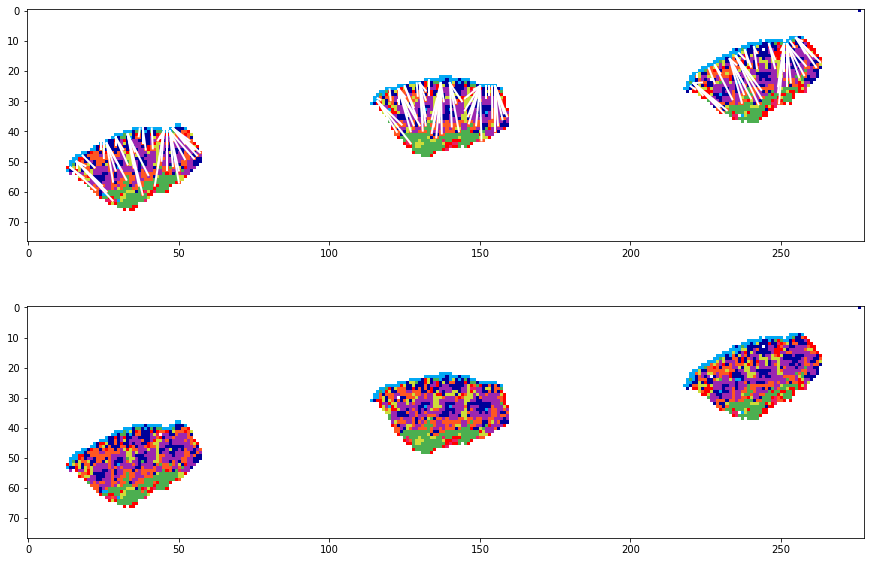

In [114]:
visualize_(color_img, valid_center, nearest)

## Criteria 2: Perifolliculitis
    create zero mask
    dfs from each follicle region, search inflammation

side_count = 275
contact area = 203.0


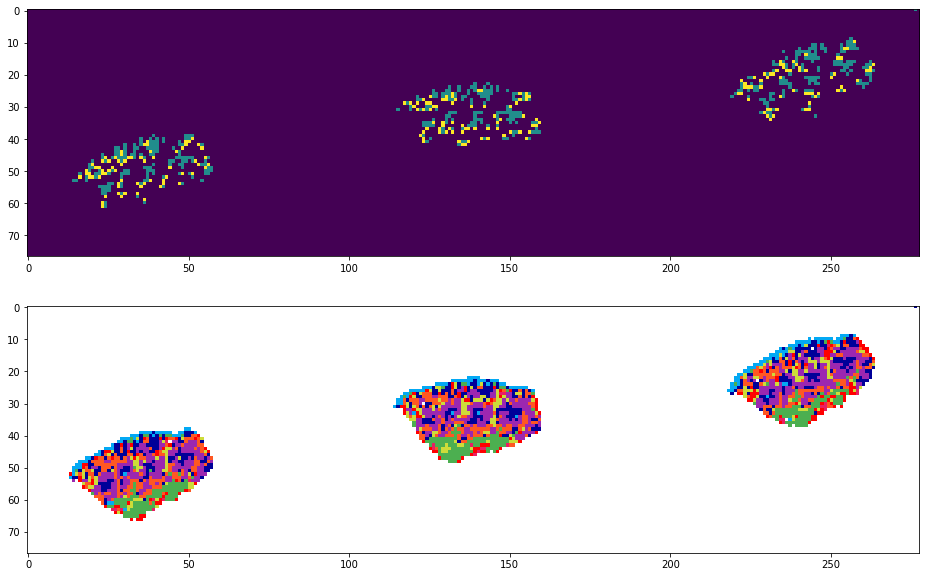

In [128]:
contact_mask = np.zeros(test_img.shape[:2])
visit_mask   = np.zeros(test_img.shape[:2])
dirs = [(-1, 0), (1, 0), (0, 1), (0, -1)]


def dfs(image, x, y, side_count):
    if visit_mask[x, y] == 1:
        return
    visit_mask[x,y] = 1
    #print(f"Checking ({x}, {y})")
    for dx, dy in dirs:
        # is inflammation
        if x+dx < 0 or x+dx >= image.shape[0] or y+dy < 0 or y+dy >= image.shape[1]:
            continue
        if image[x+dx, y+dy] == 1:
            contact_mask[x+dx, y+dy] = 1
            side_count[0] += 1
        if image[x+dx, y+dy] == 4 and visit_mask[x+dx, y+dy] ==0:
            dfs(image, x+dx, y+dy, side_count)
    
follicle_region=segment_region(test_img == 4)
xs = [x for region in follicle_region for x in region[0]]
ys = [y for region in follicle_region for y in region[1]]
side_count = [0]
for i in range(len(xs)):
    dfs(test_img, xs[i], ys[i], side_count)

print(f"side_count = {side_count[0]}")
print(f"contact area = {np.sum(contact_mask)}")
fig3 = plt.figure(figsize=(20, 10))
ax = fig3.add_subplot(2, 1, 1)
ax.imshow(contact_mask*255+np.array((test_img==4), dtype=np.uint8)*125)
ax = fig3.add_subplot(2, 1, 2)
ax.imshow(color_img)
plt.show()

## Criteria 3: Lymphocyte area/Tissue area
    for each contiguous lymphocyte aggregate:
        set_list <-- lymphocyte aggregate
    tissue set < -- scipy label
    for each set in set_list:
        tissue segment = check tissue segment number by first element of set
        print(len(set), len(tissue segment))

4


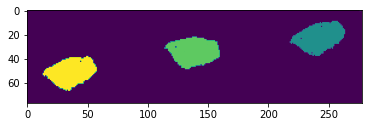

In [129]:
tissue_labels, numL = label(test_img>0)
tissue_area = [sum(tissue_labels == i) for i in range(1, numL)]
print(numL)
plt.imshow(tissue_labels)
plt.show()

In [130]:
tissue_labels, tissue_area = compute_areas(test_img>0)


for inf_region in inf_regions:
    x, y = inf_region[0][0], inf_region[1][0]
    tissue_id = tissue_labels[x, y]
    print(f"Inf area = {inf_region[0].shape[0]}, Tissue area={tissue_area[tissue_id]}")


Inf area = 1, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 2, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 2, Tissue area=830
Inf area = 2, Tissue area=830
Inf area = 7, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 4, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 2, Tissue area=830
Inf area = 3, Tissue area=830
Inf area = 22, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 3, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 4, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 8, Tissue area=830
Inf area = 1, Tissue area=830
Inf area = 2, Tissue area=846
Inf area = 1, Tissue area=830
Inf area = 14, Tissue area=830
Inf area = 1, Tissue area=830
Inf area

## Criteria 4: Lymphocyte, Adipose tissue area

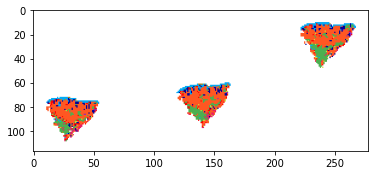

In [131]:
adipose_img, color_adipose = df2thumbnail(pd.read_csv(ADIP_IMG))
plt.imshow(color_adipose)
plt.show()

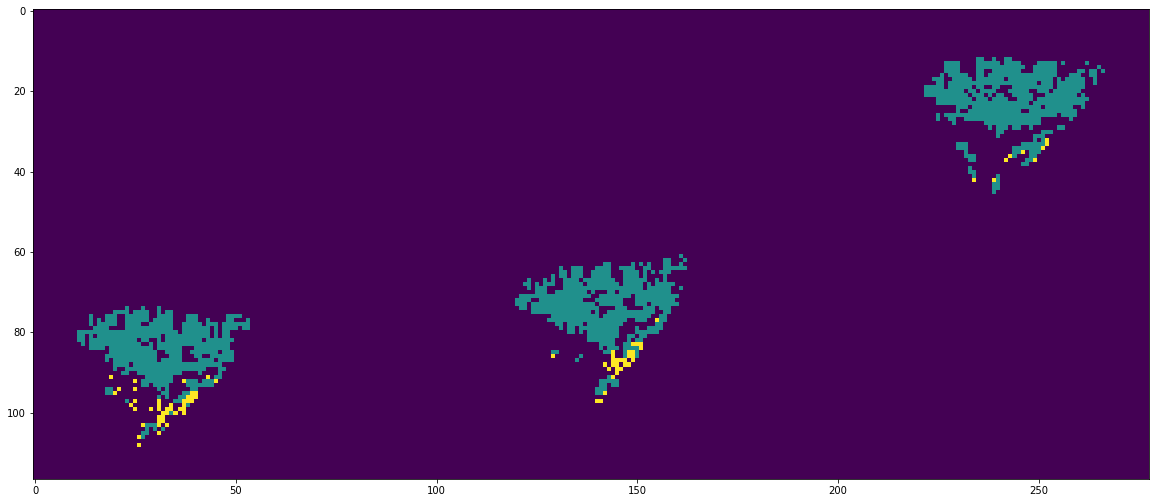

In [132]:
adipose_mask = adipose_img==2
inf_mask     = adipose_img==1
fig4 = plt.figure(figsize=(20, 10))
plt.imshow(inf_mask*0.5 + adipose_mask)
plt.show()

In [133]:
class DFS:
    def __init__(self, image, interest_id, inf_id):
        self.image = image
        self.interest_id = interest_id
        self.inf_id = inf_id
        self.visit_mask = np.zeros(image.shape[:2])
        self.contact_mask = np.zeros(image.shape[:2])
        self.interest_mask = image == interest_id
        self.inf_mask = image == inf_id
        self.contact_count = 0
        self.dirs = [(-1, 0), (1, 0), (0, 1), (0, -1)]
        
    def solve(self):
        xs, ys = np.nonzero(self.interest_mask)
        for i in range(len(xs)):
            self.idfs(xs[i], ys[i])
        return self.contact_count, np.sum(self.interest_mask)
    
    def dfs(self, x, y):
        if self.visit_mask[x, y] == 1:
            return
        self.visit_mask[x, y] = 1
        for dx, dy in self.dirs:
            if x+dx < 0 or x+dx >= self.image.shape[0] or y+dy < 0 or y+dy >= self.image.shape[1]:
                return
            if self.image[x+dx, y+dy] == self.inf_id:
                self.contact_mask[x+dx, y+dy] = 1
                self.contact_count += 1
            if self.image[x+dx, y+dy] == self.interest_id and self.visit_mask[x+dx, y+dy] == 0:
                self.dfs(x+dx, y+dy)
                
    def idfs(self, x, y):
        if self.visit_mask[x, y] == 1:
            return
        self.visit_mask[x, y] = 1
        
        stack = [(x, y)]
        
        while(stack):
            x, y = stack.pop()
            for dx, dy in self.dirs:
                if x+dx < 0 or x+dx >= self.image.shape[0] or y+dy < 0 or y+dy >= self.image.shape[1]:
                    continue
                if self.image[x+dx, y+dy] == self.inf_id:
                    self.contact_mask[x+dx, y+dy] = 1
                    self.contact_count += 1
                if self.image[x+dx, y+dy] == self.interest_id and self.visit_mask[x+dx, y+dy] == 0:
                    self.visit_mask[x+dx, y+dy] = 1
                    stack.append((x+dx, y+dy))

In [136]:
adipose_solver = DFS(adipose_img, interest_id=2, inf_id=1)
contact_count, adipose_area = adipose_solver.solve()
print(contact_count, adipose_area)

55 82


## Try binary decision tree

In [172]:
x_df = pd.read_csv(SAVE_PATH)

In [173]:
y_df = pd.read_csv(LABEL_PATH)

In [174]:
y_df

,slide_no,superficial_perivascular,superficial_and_deep_perivascular,Periadnexal,nodular,diffuse,vasculitis,folliculitis,septal_panniculitis,lobular_panniculitis,final_diagnosis
0,2019-10-30 02.05.46.ndpi,1,0,1,0,0,0,0,0,0,Diagnosis: Psoriasiform dermatitis with reacti...
1,2019-10-30 02.04.50.ndpi,1,0,1,0,0,0,0,0,0,Diagnosis: Acute cutaneous lupus erythematosus...
2,2019-10-30 02.09.05.ndpi,1,0,0,0,0,0,0,0,0,Diagnosis: Slight spongiotic psoriasiform derm...
3,2019-10-30 02.07.27.ndpi,1,0,0,0,0,0,0,0,0,"Diagnosis: Spongiotic psoriasiform dermatitis,..."
4,2019-10-30 02.10.47.ndpi,1,0,0,0,0,0,0,0,0,"Diagnosis: Compatible with contact dermatitis,..."
5,2019-10-30 02.14.37.ndpi,1,0,0,0,0,0,0,0,0,"Diagnosis: Spongiotic dermatitis, suggestive o..."
6,2019-10-30 02.18.03.ndpi,1,0,1,0,0,0,0,0,0,"Diagnosis: Vitiligo, left cheek. (Biopsy)\n Mi..."
7,2019-10-30 02.19.24.ndpi,0,0,0,0,0,0,0,0,0,"Diagnosis: Lipoma, forehead. (Excision)\n Micr..."
8,2019-10-30 02.15.32.ndpi,0,1,0,0,0,0,0,0,0,"Diagnosis: Osteo-nevus of Nanta, left cheek. (..."
9,2019-10-30 02.23.07.ndpi,1,0,0,0,0,0,0,0,0,"Diagnosis: Neurofibroma, right forehead. (Exci..."


In [204]:
x_train = np.array([ls[1:] for ls in x_df.to_dict("split")['data']])
x_order = [ls[0] for ls in x_df.to_dict("split")['data']]
features = x_df.to_dict("split")['columns'][1:]
features

['inf_mean_dist',
 'inf_var_dist',
 'fat_contact',
 'fat_area',
 'hair_contact',
 'hair_area',
 'max_inf_ratio']

In [210]:
def rearrange(df, order):
    ret = []
    for slide_name in order:
        for i in df.index:
            if df["slide_no"][i] == slide_name:
                ret.append(np.array(df.iloc[i][1:-1]))
    return np.array(ret)

labels = rearrange(y_df, x_order).astype(np.int32)
class_names = np.array(y_df.columns[1:-1]).astype(str)
class_names
#labels 


array(['superficial_perivascular', 'superficial_and_deep_perivascular',
       'Periadnexal', 'nodular', 'diffuse', 'vasculitis', 'folliculitis',
       'septal_panniculitis', 'lobular_panniculitis'], dtype='<U33')

In [184]:
x_y = np.where(labels > 0)
print(x_y)
a = [x_y[1][(x_y[0] == i)] for i in range(len(labels))]
print(a)

(array([ 0,  0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  4,  4,  5,  6,  7,  8,
        9,  9, 11, 12, 13, 13, 13, 14, 14, 14, 15]), array([1, 2, 6, 1, 2, 8, 0, 2, 1, 2, 6, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0,
       2, 6, 0, 2, 6, 0]))
[array([1, 2, 6]), array([1, 2, 8]), array([0, 2]), array([1, 2, 6]), array([0, 2]), array([0]), array([0]), array([0]), array([0]), array([0, 2]), array([], dtype=int64), array([1]), array([0]), array([0, 2, 6]), array([0, 2, 6]), array([0])]


### Take 1: sklearn decision tree

In [190]:
clf = tree.DecisionTreeClassifier()

In [221]:
clf = clf.fit(x_train, labels)

[Text(122.33076923076923, 199.32, 'X[3] <= 88.0\ngini = 0.2\nsamples = 16\nvalue = [[5, 11]\n[12, 4]\n[8, 8]\n[16, 0]\n[16, 0]\n[16, 0]\n[12, 4]\n[16, 0]\n[15, 1]]'),
 Text(51.50769230769231, 163.07999999999998, 'X[5] <= 334.0\ngini = 0.111\nsamples = 2\nvalue = [[2, 0]\n[0, 2]\n[0, 2]\n[2, 0]\n[2, 0]\n[2, 0]\n[1, 1]\n[2, 0]\n[1, 1]]'),
 Text(25.753846153846155, 126.83999999999999, 'gini = 0.0\nsamples = 1\nvalue = [[1, 0]\n[0, 1]\n[0, 1]\n[1, 0]\n[1, 0]\n[1, 0]\n[1, 0]\n[1, 0]\n[0, 1]]'),
 Text(77.26153846153846, 126.83999999999999, 'gini = 0.0\nsamples = 1\nvalue = [[1, 0]\n[0, 1]\n[0, 1]\n[1, 0]\n[1, 0]\n[1, 0]\n[0, 1]\n[1, 0]\n[1, 0]]'),
 Text(193.15384615384616, 163.07999999999998, 'X[1] <= 36.722\ngini = 0.156\nsamples = 14\nvalue = [[3, 11]\n[12, 2]\n[8, 6]\n[14, 0]\n[14, 0]\n[14, 0]\n[11, 3]\n[14, 0]\n[14, 0]]'),
 Text(128.76923076923077, 126.83999999999999, 'X[0] <= 3.604\ngini = 0.14\nsamples = 10\nvalue = [[1, 9]\n[9, 1]\n[4, 6]\n[10, 0]\n[10, 0]\n[10, 0]\n[7, 3]\n[10, 0]\n[

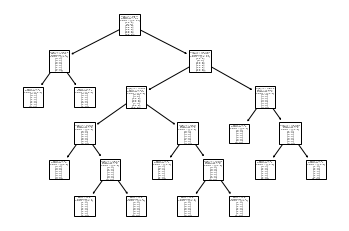

In [222]:
tree.plot_tree(clf) 

In [223]:
out = clf.predict(x_train)
out == labels

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True, 

In [224]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=features,  
                      class_names=class_names,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data) 

In [ ]:
graph

In [231]:
import xgboost as xgb
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

In [237]:
xgb_model = OneVsRestClassifier(xgb.XGBClassifier(n_jobs=-1, max_depth=10))
xgb_model.fit(x_train, labels)

/usr/local/lib/python3.8/site-packages/sklearn/multiclass.py:74: UserWarning: Label not 3 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/usr/local/lib/python3.8/site-packages/sklearn/multiclass.py:74: UserWarning: Label not 4 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/usr/local/lib/python3.8/site-packages/sklearn/multiclass.py:74: UserWarning: Label not 5 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %
/usr/local/lib/python3.8/site-packages/sklearn/multiclass.py:74: UserWarning: Label not 7 is present in all training examples.
  warnings.warn("Label %s is present in all training examples." %


OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=10,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='binary:logistic',
                                            rand

In [239]:
labels

array([[0, 1, 1, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)